In [1]:
import os
import inspect
import sys

In [2]:
import sys
sys.path.append("../")
sys.path.append('../../../')

In [3]:
from gnn_boundary.datasets import *
from gnn_boundary.models import *
from gnn_boundary.utils import *
from gnn_boundary.criteria import *
from gnn_boundary.regularizations import *
from gnn_boundary import Trainer, Evaluator, GraphSampler

import shelve
import torch
import numpy as np

from DatasetWrapper import *

C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from graph_generation import GridGraphs as GG

In [5]:
dataset = GG.GridGraphs(2000).getDataset()
num_cls = 2

In [6]:
dataset = DatasetWrapper(dataset, num_cls=2, node_feat= 3,name="grid_graphs")

In [7]:
import explainers.GNNBoundary.gnn_boundary.models as models

In [8]:
model = models.GCNClassifier(hidden_channels = 16, node_features = 3, num_classes=2)

In [9]:
import os
cwd = os.getcwd()
file_path = os.path.abspath(os.path.join(cwd, '../../../model/report_models/grids.pt'))

In [10]:
model.load_state_dict(torch.load(file_path))

<All keys matched successfully>

In [11]:
dataset_list_gt = dataset.split_by_class()
dataset_list_pred = dataset.split_by_pred(model)

C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [12]:
evaluation = dataset.model_evaluate(model)
evaluation

{'acc': 1.0,
 'cm': array([[2500,    0],
        [   0, 2500]], dtype=int64),
 'f1': {0: 1.0, 1: 1.0}}

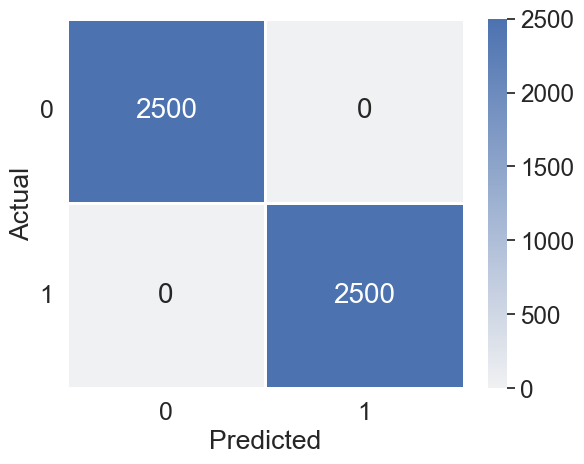

In [13]:
draw_matrix(evaluation['cm'], dataset.GRAPH_CLS.values(), fmt='d')

In [14]:
mean_embeds = [d.model_transform(model, key="embeds").mean(dim=0) for d in dataset_list_gt]

C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


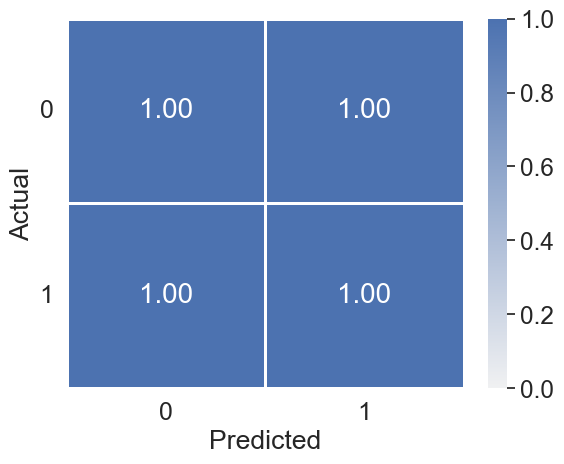

In [15]:
adj_ratio_mat, boundary_info = pairwise_boundary_analysis(model, dataset_list_pred)
draw_matrix(adj_ratio_mat, names=dataset.GRAPH_CLS.values(), fmt='.2f')

In [16]:
trainer = {}
sampler = {}

In [23]:
from gnn_boundary import Trainer
from utility_functions import *

In [18]:
def hyperparameterBoundary(max_nodes, lr, target_size):
    cls_1, cls_2 = 0, 1
    trainer[cls_1, cls_2] = Trainer(
        sampler=(s := GraphSampler(
            max_nodes=max_nodes,
            temperature=0.5,
            num_node_cls=3,#len(dataset.NODE_CLS),
            learn_node_feat=True
        )),
        discriminator=model,
        criterion=WeightedCriterion([
            dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
                classes=[cls_1, cls_2], alpha=1, beta=2
            ), weight=25),
            dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
            dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
            dict(key="logits", criterion=MeanPenalty(), weight=1),
            dict(key="omega", criterion=NormPenalty(order=1), weight=1),
            dict(key="omega", criterion=NormPenalty(order=2), weight=1),
            # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
            # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
            # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
            # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
            dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
        ]),
        optimizer=(o := torch.optim.SGD(s.parameters(), lr=lr)),
        scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
        dataset=dataset,
        budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
    )
    
    trainer[0, 1].train(
        iterations=1000,
        target_probs={cls_1: (0.3, 0.7), cls_2: (0.3, 0.7)},
        target_size= target_size,
        w_budget_init=1,
        w_budget_inc=1.1,
        w_budget_dec=0.95,
        k_samples=16
    )

    explain_graph = trainer[0, 1].evaluate(threshold=0.5, show=False)
    graph = dataset.convertNxToData(explain_graph)
    return graph
    


In [19]:
max_nodes_li = [15, 20, 25]
lr_li = [0.5,0.05, 0.005]
target_size_li = [15,25,30]
class_1 = 0
class_2 = 1


In [20]:
criteria_function = lambda x,y: (1-x)**2 + (1-y)**2

best_probs = (0,1)
best_graph = None
best_hyperparameters = (0,0,0)
for max_nodes in max_nodes_li:
    for lr in lr_li:
        for target_size in target_size_li:
            try:
                graph = hyperparameterBoundary(max_nodes = max_nodes,lr = lr, target_size = target_size)
                probs = (model(graph)["probs"].squeeze()[class_1].item(),model(graph)["probs"].squeeze()[class_2].item())
                print(f"MN: {max_nodes} LR: {lr} TS: {target_size} Probs: {probs}")
                if criteria_function(*best_probs) > criteria_function(*probs):
                    best_probs = probs
                    best_graph = graph
                    best_hyperparameters = (max_nodes, lr, target_size)
            except Exception as e:
                if str(e) == "Empty graph!":
                    print("Caught an Empty graph exception")
                    print(f"MN: {max_nodes} LR: {lr} TS: {target_size}")
                



100%|██████████| 1000/1000 [00:23<00:00, 42.26it/s]


MN: 15 LR: 0.5 TS: 15 Probs: (0.9999997615814209, 1.8964580306146672e-07)


  1%|          | 7/1000 [00:00<00:38, 26.13it/s]


MN: 15 LR: 0.5 TS: 25 Probs: (1.0, 6.628853715939798e-11)


 25%|██▌       | 252/1000 [00:05<00:16, 45.55it/s]


MN: 15 LR: 0.5 TS: 30 Probs: (1.0, 2.4442673057822103e-15)


100%|██████████| 1000/1000 [00:22<00:00, 43.68it/s]


Caught an Empty graph exception
MN: 15 LR: 0.05 TS: 15


 20%|██        | 204/1000 [00:04<00:18, 42.68it/s]


MN: 15 LR: 0.05 TS: 25 Probs: (2.375629026829529e-09, 1.0)


  4%|▍         | 42/1000 [00:01<00:22, 41.82it/s]


MN: 15 LR: 0.05 TS: 30 Probs: (0.9999947547912598, 5.294376933306921e-06)


100%|██████████| 1000/1000 [00:22<00:00, 45.07it/s]


MN: 15 LR: 0.005 TS: 15 Probs: (1.0, 2.9956450653401134e-09)


 12%|█▏        | 117/1000 [00:03<00:23, 36.91it/s]


MN: 15 LR: 0.005 TS: 25 Probs: (4.372378725747694e-08, 1.0)


 11%|█         | 106/1000 [00:02<00:20, 44.03it/s]


MN: 15 LR: 0.005 TS: 30 Probs: (1.0, 1.659548375465702e-16)


100%|██████████| 1000/1000 [00:23<00:00, 42.04it/s]


MN: 20 LR: 0.5 TS: 15 Probs: (1.0, 1.0691613745597919e-13)


 81%|████████▏ | 814/1000 [00:19<00:04, 41.92it/s]


MN: 20 LR: 0.5 TS: 25 Probs: (0.9999994039535522, 5.715505722037051e-07)


  0%|          | 5/1000 [00:00<01:40,  9.88it/s]


MN: 20 LR: 0.5 TS: 30 Probs: (0.9985361099243164, 0.001463837455958128)


100%|██████████| 1000/1000 [00:25<00:00, 39.95it/s]


MN: 20 LR: 0.05 TS: 15 Probs: (0.9959468245506287, 0.004053217824548483)


100%|██████████| 1000/1000 [00:24<00:00, 41.11it/s]


MN: 20 LR: 0.05 TS: 25 Probs: (1.0, 5.808931352428715e-13)


100%|██████████| 1000/1000 [00:24<00:00, 41.27it/s]


Caught an Empty graph exception
MN: 20 LR: 0.05 TS: 30


100%|██████████| 1000/1000 [00:24<00:00, 41.31it/s]


MN: 20 LR: 0.005 TS: 15 Probs: (0.02013721503317356, 0.9798627495765686)


 33%|███▎      | 331/1000 [00:08<00:16, 39.62it/s]


MN: 20 LR: 0.005 TS: 25 Probs: (1.0, 3.0718270283811066e-15)


100%|██████████| 1000/1000 [00:26<00:00, 38.37it/s]


MN: 20 LR: 0.005 TS: 30 Probs: (0.9992183446884155, 0.0007816964644007385)


  0%|          | 3/1000 [00:00<05:03,  3.28it/s]


MN: 25 LR: 0.5 TS: 15 Probs: (0.9999997615814209, 2.1386968285241892e-07)


  1%|          | 6/1000 [00:00<02:40,  6.19it/s]


MN: 25 LR: 0.5 TS: 25 Probs: (0.19929392635822296, 0.8007060289382935)


100%|██████████| 1000/1000 [00:26<00:00, 37.64it/s]


MN: 25 LR: 0.5 TS: 30 Probs: (0.2825029790401459, 0.7174970507621765)


100%|██████████| 1000/1000 [00:25<00:00, 38.87it/s]


MN: 25 LR: 0.05 TS: 15 Probs: (0.9999967813491821, 3.224834472348448e-06)


100%|██████████| 1000/1000 [00:26<00:00, 38.13it/s]


MN: 25 LR: 0.05 TS: 25 Probs: (1.0, 1.6335365654441207e-19)


100%|██████████| 1000/1000 [00:25<00:00, 39.10it/s]


MN: 25 LR: 0.05 TS: 30 Probs: (0.004224665462970734, 0.9957754015922546)


100%|██████████| 1000/1000 [00:25<00:00, 38.63it/s]


MN: 25 LR: 0.005 TS: 15 Probs: (2.1772073033332617e-09, 1.0)


 92%|█████████▏| 923/1000 [00:23<00:01, 39.27it/s]


MN: 25 LR: 0.005 TS: 25 Probs: (0.00023517214867752045, 0.9997648596763611)


 44%|████▎     | 435/1000 [00:11<00:14, 38.36it/s]


MN: 25 LR: 0.005 TS: 30 Probs: (1.0, 3.4884168886861744e-09)


(0.2825029790401459, 0.7174970507621765)
(25, 0.5, 30)


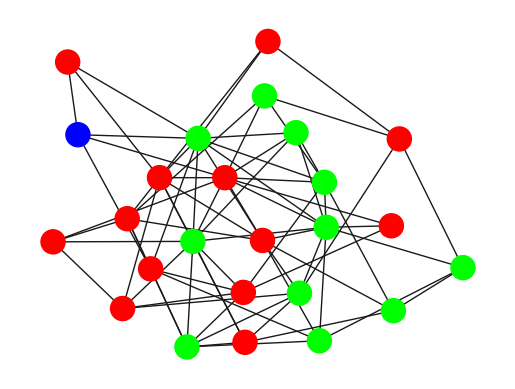

In [21]:
print(best_probs)
print(best_hyperparameters)
printGraph(best_graph, "./images/GridBoundary1")